__Project:__ Intent Recognition <br> 
__Sub-prj:__ Senstivity Analysis: _number of labels & data fraction_ <br>
__Experm:__  Distilbert-base-uncased <br>
__Devl by:__ Amir Hossini <br>
__Dev Dat:__ Oct 13, 2021 <br>

#### Libraries

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

print(f"Tensorflow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.5.0
Transformers version: 4.11.3
Num GPUs Available:  1


#### I/O Files & Params

In [147]:
fl_train = '../datasets/banking77/train.csv'
fl_test  = '../datasets/banking77/test.csv'

experiment_grid = {
    'n_labels'  : [3, 10, 20, 77],
    'train_frac': [1., 0.5, 0.1]
}

seed = 42

#### Functions

In [175]:
def select_data(train, test, col_label, n_labels=None, train_frac=None):
    if n_labels is None:
        n_labels = len(train.loc[:,col_label].unique())
    if train_frac is None:
        train_frac = 1
        
    select_labels = np.array(train.loc[:,col_label].value_counts()[0:n_labels].index)
    select_train  = train.loc[train[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_train  = len(select_train)
    n_data_select = int(n_data_train * train_frac)
    indx_select   = np.random.choice(range(n_data_train),n_data_select)
    select_train  = select_train.iloc[indx_select,:]
    select_train  = select_train.reset_index(drop=True)
    select_test   = test.loc[test[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_test   = len(select_test)
    indx_test     = np.random.choice(range(n_data_test),n_data_test)
    select_test   = select_test.iloc[indx_test,:]
    select_test   = select_test.reset_index(drop=True)
    return select_train, select_test

def factorize_data(train, test, col_label,return_keys=False):
    train_labels, levels = pd.factorize(train.loc[:,col_label])
    categs = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().index
    labels = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().values.T[0]
    label_keys=dict(zip(categs,labels))
    test_labels = test.loc[:,col_label].map(lambda x: label_keys[x])
    train.loc[:,col_label]=train_labels
    test.loc[:,col_label]=test_labels
    if return_keys:
        return train, test, label_keys
    else:
        return train, test
    
def tokenize_encode_data(train,test,col_text,col_label,checkpoint='distilbert-base-uncased',
                         truncation_flag=True, padding_flag=True, return_tensors_opt='tf'):
    train_sentences = list(train.loc[:,col_text])
    test_sentences  = list(test.loc[:,col_text])
    train_labels    = list(train.loc[:,col_label])
    test_labels     = list(test.loc[:,col_label])
    tokenizer       = AutoTokenizer.from_pretrained(checkpoint)
    train_encodings = tokenizer(train_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    test_encodings  = tokenizer(test_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    train_dataset   = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
    test_dataset    = tf.data.Dataset.from_tensor_slices((dict(test_encodings),test_labels))
    return train_dataset, test_dataset 

def transformer_model(train_dataset,test_dataset,n_labels,lr=5e-5,
                      epochs=10,batch_size=64,checkpoint='distilbert-base-uncased'):
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_labels)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    history = model.fit(train_dataset,epochs=epochs,batch_size=batch_size,
          validation_data=test_dataset)
    return history

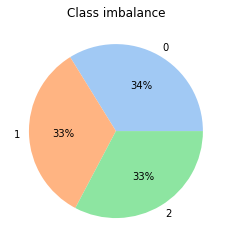

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


ValueError: in user code:

    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\transformers\modeling_tf_utils.py:769 train_step
        loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\losses.py:1712 sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\backend.py:4979 sparse_categorical_crossentropy
        res = nn.sparse_softmax_cross_entropy_with_logits_v2(
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\ops\nn_ops.py:4228 sparse_softmax_cross_entropy_with_logits_v2
        return sparse_softmax_cross_entropy_with_logits(
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\ops\nn_ops.py:4133 sparse_softmax_cross_entropy_with_logits
        raise ValueError("Shape mismatch: The shape of labels (received %s) "

    ValueError: Shape mismatch: The shape of labels (received (1,)) should equal the shape of logits except for the last dimension (received (73, 3)).


In [176]:
n_labels = 3
train_frac = 0.5

np.random.seed(seed)
train = pd.read_csv(fl_train)
test  = pd.read_csv(fl_test)

train, test = select_data(train, test, 'category', n_labels, train_frac)
train, test = factorize_data(train, test, 'category')

colors = sns.color_palette('pastel')[0:n_labels]
_ = plt.pie(list(train['category'].value_counts()), 
            labels = list(train['category'].value_counts().index), 
            colors = colors, 
            autopct='%.0f%%')
_ = plt.title('Class imbalance')
_ = plt.show()

train_dataset, test_dataset = tokenize_encode_data(train,test,'text','category',checkpoint='distilbert-base-uncased')
history                     = transformer_model(train_dataset,test_dataset,n_labels)